In [1]:
import pyross
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [2]:
####################################
##                                ##
##   Population Characteristics   ##
##                                ##
####################################

#########################################
##        Population Numbers           ##
#########################################

M=16  ## number of age classes
Ni = pyross.utils.getPopulation(country='UK', M=M)
min_age = 2.5; max_age = 77.5; age = np.linspace(min_age,max_age, M)
N = np.sum(Ni)

#########################################
##          Contact Matrices           ##
#########################################

# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.UK()
def contactMatrix(t):
#     if t > 3000 and t < 90:
#         return CH + 0.1*CW + 0.1*CO
#     else:
        return CH + CW + CS + CO

In [3]:
####################################
##                                ##
##    Disease Characteristics     ##
##                                ##
####################################

## All rates defined in units of 1/day ##

beta  = 0.0192          # infection rate constant
gE    = 1/2.72            # rate constant:  Exposed to asymptomatic
gA    = 1/3.12            # rate constant:  Activated to Infected
gIa   = 1/7               # rate constant:  Asymptomatic to Recovery
gIs = 1/7 


#######################
##     Splitters    ###
#######################

## Splitters are age-structured using the fitted form suggested by Jakub ##

alpha = 0.66*np.exp(-age/50.5)      # fraction of Activated    that follow asymptomatic branch 


#######################
##    Modulators     ##
#######################

fsa   = 1.0               # the self-isolation parameter [Relative exposure of symptomatics, 1 = fully exposed]

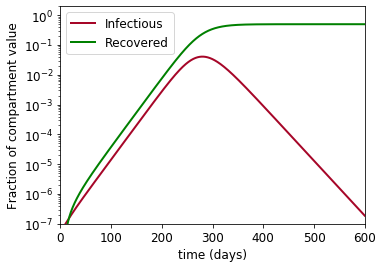

In [4]:
Nf = 1200
Tf = 600

S0 = Ni
Ia0 = np.zeros((M))
Ia0[2] += 5
S0[2] -= 5

Is0 = np.zeros((M))
E0 = np.zeros((M))

# instantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gE':gE, 'fsa':fsa} 
model = pyross.deterministic.SEIR(parameters, M, Ni)
data  = model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)

## Plot Results ##

Infectious = np.sum((model.Is(data) + model.Ia(data)), axis=1) 
R = np.sum(model.R(data), axis=1)

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.semilogy(data['t'], Infectious/N,  color = "#A60628", label = 'Infectious' ,lw = 2)
plt.semilogy(data['t'], R/N,              color = 'green',   label = 'Recovered'  ,lw = 2)
plt.xlabel('time (days)');       
plt.xlim(0,Tf);  
plt.ylim(1e-7,2)
plt.ylabel('Fraction of compartment value');   
plt.legend()
plt.show() 

-6202.523879766464


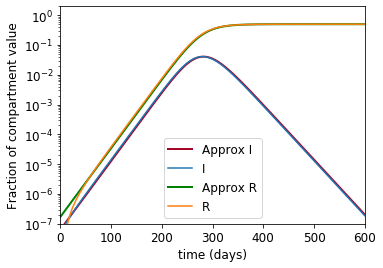

In [5]:
Nf = 1200
Tf = 600
 
# Initialise the model and find the fastest growing linear mode 
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gE':gE, 'fsa':fsa} 
estimator = pyross.inference.SEIR(parameters, M, Ni)

# Sets the contact matrix 
estimator.set_contact_matrix(contactMatrix)
v = estimator.find_fastest_growing_lin_mode(0)
v = v/np.linalg.norm(v, ord=1)

if v[0] > 0: 
    v = -v 

# Find the coefficient of the fastest growing linear 
pert = np.zeros((M*4))
pert[:M] = - (E0+Ia0+Is0)
pert[M:2*M] = E0
pert[2*M:3*M] = Ia0 
pert[3*M:4*M] = Is0
coeff = np.linalg.norm(pert, ord=1)


# Find the Kreiss constant (good approximation when initial growth state is not yet reached)
from scipy import sparse
J = estimator.J_mat[M:, M:]
eigval = sparse.linalg.eigs(J, k=1, which='LR')
eigval = np.real(eigval[0])
Jp = J - eigval*np.identity(J.shape[0])
res = pyross.contactMatrix.characterise_transient(Jp, ord=1)
K = np.real(res[2])

# simulate with only the fastest growing linear mode 
zero_state = np.zeros((M*4))
zero_state[:M] = Ni
x0_approx = zero_state + coeff*v*K

estimator.set_det_model(parameters)
x = estimator.integrate(x0_approx, 0, Tf, Nf)


# Plot Results 

x = np.array(x).reshape((Nf, 4, M))

Infectious_approx = np.sum(np.sum(x[:, 2:, :], axis=1), axis=1)
R_approx = np.sum(Ni - np.sum(x, axis=1), axis=1)

print(R[-1] - R_approx[-1])

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.semilogy(data['t'], Infectious_approx/N, color = "#A60628", label = 'Approx I' ,lw = 2)
plt.semilogy(data['t'], Infectious/N, label='I')
plt.semilogy(data['t'], R_approx/N, color = 'green',   label = 'Approx R'  ,lw = 2)
plt.semilogy(data['t'], R/N, label='R')
plt.xlabel('time (days)')    
plt.xlim(0,Tf)
plt.ylim(1e-7,2)
plt.ylabel('Fraction of compartment value')
plt.legend()
plt.show() 